# **Ozempic's Therapeutic Outcomes on Obesity and Hypertension**

### Yuewen (Alison) Shen

## **Data Preprocessing and Merging**

In [67]:
# import library
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import operator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
import math

### **Data resource 1: Medical Information**

In [68]:
# Read and display the the medical claims dataset for initial inspection
medical = pd.read_csv('./medical.csv')

# Drop duplicated rows
medical = medical.drop_duplicates()

# Filter the dataset to only keep patients aged between 40 - 75
medical = medical[(medical['patient_age'] >= 40) & (medical['patient_age'] <= 75)]
medical.head()

,journey_id,episode_id,visit_id,encounter_id,claim_date,patient_state,patient_short_zip,patient_age,patient_gender,place_of_service,...,diag_4,diag_5,rev_center_code,rev_center_units,proc_code,proc_modifier,proc_units,line_charge,claim_charge,smart_allowed
0,00006390c96ebfffed580074c35a16a7,d5e15811af1d772f54af52f3560be0a5,f22b7ab885c44afae5449d74f8498f53aea1b2cfa79598...,d5a7dc61071d977cef9ff762973d360f4bcf15a19790d9...,2020-07-13,CA,922.0,55.0,M,Home,...,NaN,NaN,NaN,1.0,A6549,NU,2.0,300.00,300.00,974.13
2,00006390c96ebfffed580074c35a16a7,e25e5285e4f66d35c9840bf4e040fe73,3f45ba8ebef02b0c09b09e864e57ba5ee9d6bc9acf1c39...,c60da949b58f0351c8781c062f65d92bce76d9532d1632...,2023-07-19,CA,922.0,60.0,M,Office,...,L03115,L03116,NaN,1.0,3074F,NaN,1.0,0.00,0.00,46.57
3,00006390c96ebfffed580074c35a16a7,e25e5285e4f66d35c9840bf4e040fe73,3f45ba8ebef02b0c09b09e864e57ba5ee9d6bc9acf1c39...,c60da949b58f0351c8781c062f65d92bce76d9532d1632...,2023-07-19,CA,922.0,60.0,M,Office,...,L03115,L03116,NaN,1.0,3078F,NaN,1.0,0.00,0.00,56.38
4,00006d564a4718c744f1bbf1b6c5f8c3,42ba4419d9ad7c9293d76686fb608f10,9e4534892128401c693a6ab2ea758cd6a0a6484972168b...,da5cef18317c14180ed561a84001d8a033d724d541a2c0...,2023-08-11,CA,900.0,55.0,F,Independent Laboratory,...,NaN,NaN,NaN,1.0,80053,NaN,1.0,88.07,88.07,15.16
5,00006d564a4718c744f1bbf1b6c5f8c3,cad5e8635fd011bfec2b65d161b15254,3b0f0f71ac05c34ab9307c4853f1af59420c07b522cdf2...,eafff3ebf33ebe534edc66e761d9b52d1381653d9d0d57...,2019-11-01,CA,900.0,50.0,F,Office,...,M4317,N200,NaN,1.0,72072,NaN,1.0,107.00,107.00,72.42


In [70]:
# Calculate the ratio of missing values for each column in medical data
missing_value_ratio = (medical.isna().sum() / len(medical)) * 100
missing_value_ratio = missing_value_ratio[missing_value_ratio > 0]
print(missing_value_ratio)

visit_id              0.218944
patient_short_zip     0.002370
place_of_service     21.068578
visit_type            3.533184
payor                 2.389425
payor_channel         6.179472
ref_npi              51.634515
hcp_npi              29.672842
hcp_taxonomy         30.674224
hcp_specialty        30.672765
hco_npi               0.930284
hcp_npi_list         29.672842
hco_npi_list          0.930284
diag_list             0.145477
diag_1                0.145477
diag_2               26.137288
diag_3               41.420165
diag_4               52.155168
diag_5               67.233503
rev_center_code      82.699046
rev_center_units      0.234075
proc_code             3.156732
proc_modifier        73.489359
proc_units            0.294235
dtype: float64


In [71]:
# Remove features don't necessary need for the effect of Ozempic prediction generally: patient_state(replaced by 'patient_short_zip'), diag_list(replaced by 'diag_')
medical.drop(columns=['episode_id', 'visit_id', 'encounter_id', 'patient_state', 'payor', 'payor_channel','hcp_npi','hcp_taxonomy', 'place_of_service', 
                      'hcp_specialty','hco_npi','hcp_npi_list','hco_npi_list', 'rev_center_units', 'line_charge', 'claim_charge'], inplace=True)

# Drop features with more than 50% NaN in Medical dataset (except 'diag_4' and 'diag_5', which might be key identifiers used to predict effect of Ozempic)
medical.drop(columns=['ref_npi', 'rev_center_code', 'proc_modifier'], inplace=True)

# These variables are key identifier, so it's good to drop the rows where visiter_id is missing
medical.dropna(subset=['patient_short_zip', 'visit_type', 'diag_1','proc_code'], inplace=True)

# Use mean value for proc_units
mean_imputer = SimpleImputer(strategy='mean')
for column in ['proc_units']:
    medical[column] = np.round(mean_imputer.fit_transform(medical[[column]])).astype(int)

# Check data after dealing with missing values
print(medical.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 512915 entries, 0 to 623524
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   journey_id         512915 non-null  object 
 1   claim_date         512915 non-null  object 
 2   patient_short_zip  512915 non-null  float64
 3   patient_age        512915 non-null  float64
 4   patient_gender     512915 non-null  object 
 5   visit_type         512915 non-null  object 
 6   diag_list          512915 non-null  object 
 7   diag_1             512915 non-null  object 
 8   diag_2             377725 non-null  object 
 9   diag_3             296742 non-null  object 
 10  diag_4             239828 non-null  object 
 11  diag_5             159541 non-null  object 
 12  proc_code          512915 non-null  object 
 13  proc_units         512915 non-null  int64  
 14  smart_allowed      512915 non-null  float64
dtypes: float64(3), int64(1), object(11)
memory usage: 6

In [72]:
# Convert 'claim_date' to datetime
medical['claim_date'] = pd.to_datetime(medical['claim_date'])

# Convert zip to object
medical['patient_short_zip'] = medical['patient_short_zip'].astype(str)

#### Exploration on Medical Data

In [73]:
# 1. Select 'diag_' columns
diag_columns = [col for col in medical.columns if col.startswith('diag_')]
df_diag = medical[diag_columns]

# 2. Combine values 
combined_list = df_diag.values.flatten().tolist()
combined_list = [x for x in combined_list if pd.notna(x)]

# 3. Process first three digits
first_three_counts = {}
for diag_code in combined_list:
    first_three = diag_code[:3]
    first_three_counts[first_three] = first_three_counts.get(first_three, 0) + 1
    
# Sort the dictionary items by count (descending order)
sorted_counts = sorted(first_three_counts.items(), key=operator.itemgetter(1), reverse=True)

for items in sorted_counts[:5]:
    print(items)

('E11', 194300)
('I10', 169170)
('E78', 96020)
('Z00', 80183)
('E66', 56002)


#### Top 5 OCC
E11  Type 2 diabetes mellitus

I10  Essential (primary) hypertension

E78  Disorders of lipoprotein metabolism and other lipidemias

Z00  Encounter for general examination without complaint, suspected or reported diagnosis

E66  Overweight and obesity

In [74]:
# We only want to understand the impact of ozempic on obese and hypertensive patients
# Therefore, based on the results of Top 5 OCC, we can clean the medical data with filtering patients with 'E66' or 'I10' 
medical = medical[(medical['diag_1'].str.contains('E11|I10', na=False)) |
                 (medical['diag_2'].str.contains('E11|I10', na=False)) |
                 (medical['diag_3'].str.contains('E11|I10', na=False)) |
                 (medical['diag_4'].str.contains('E11|I10', na=False)) |
                 (medical['diag_5'].str.contains('E11|I10', na=False))]

# Meanwhile, the Ozempic was approved December 5th, 2017, so we only want the data after that time
medical = medical[medical['claim_date'] > '2017-12-05']
medical.head()

,journey_id,claim_date,patient_short_zip,patient_age,patient_gender,visit_type,diag_list,diag_1,diag_2,diag_3,diag_4,diag_5,proc_code,proc_units,smart_allowed
6,00006d564a4718c744f1bbf1b6c5f8c3,2022-09-16,900.0,50.0,F,outpatient visit,"R9431,E039,I10,Z6825",R9431,E039,I10,Z6825,NaN,1159F,1,44.68
10,00006d564a4718c744f1bbf1b6c5f8c3,2022-09-16,900.0,50.0,F,outpatient visit,"R9431,E039,I10,Z6825",R9431,E039,I10,Z6825,NaN,3008F,1,48.46
13,00006d564a4718c744f1bbf1b6c5f8c3,2022-09-16,900.0,50.0,F,outpatient visit,"R9431,E039,I10,Z6825",R9431,E039,I10,Z6825,NaN,1160F,1,42.00
16,00006d564a4718c744f1bbf1b6c5f8c3,2022-09-28,900.0,50.0,F,outpatient visit,"N200,I10,E039",N200,I10,E039,NaN,NaN,50432,1,429.73
17,00006d564a4718c744f1bbf1b6c5f8c3,2019-11-01,900.0,50.0,F,laboratory visit,"E7800,E039,I10,R809",E7800,E039,I10,R809,NaN,80053,1,15.16


### **Data resource 2: Prescription Information**

In [75]:
# Read and display the the prescription dataset for initial inspection
scripts = pd.read_csv('./scripts.csv', low_memory=False)

# Drop duplicated rows
scripts.drop_duplicates()
scripts.head(5)

,journey_id,cohort_id,claim_id,patient_gender,patient_state,patient_zip,patient_dob,pharmacy_npi,pharmacist_npi,prescriber_npi,...,bin,plan_pay,reject_code_1,reject_code_3,reject_code_4,reject_code_5,ndc,active,start_date,end_date
0,00006390c96ebfffed580074c35a16a7,16,60618bd8d37311da702bf9349e76f8c26d515c082e136f...,M,CA,922,1961-01-01,1215361126,None,1750479168,...,022659,NaN,None,None,None,None,47335067381,True,190001,None
1,00006390c96ebfffed580074c35a16a7,16,dbeb47defd161331e43f4e359e8d43e4ef7546ff58359b...,M,CA,922,1961-01-01,1215361126,None,1750479168,...,022659,NaN,None,None,None,None,47335067381,True,190001,None
2,00006390c96ebfffed580074c35a16a7,16,02927d081fad10afffcba79bad27f94ff52c98e968aaec...,M,CA,922,1961-01-01,1215361126,None,1750479168,...,022659,NaN,None,None,None,None,47335067381,True,190001,None
3,00006390c96ebfffed580074c35a16a7,16,a412c986e2503a5140ed1482e88b5ec50feeedaf2d89ec...,M,CA,922,1961-01-01,1215361126,None,1750479168,...,022659,NaN,None,None,None,None,47335067381,True,190001,None
4,00006390c96ebfffed580074c35a16a7,16,b65634edd78998753fe9606b142b2fff7765d6c576973c...,M,CA,922,1961-01-01,1215361126,None,1750479168,...,022659,NaN,None,None,None,None,65862059805,True,190001,None


In [77]:
# Calculate the ratio of missing values for each column in prescription data
missing_value_ratio = (scripts.isna().sum() / len(scripts)) * 100
missing_value_ratio = missing_value_ratio[missing_value_ratio > 0]
print(missing_value_ratio)

number_of_refills_authorized      5.041677
diagnosis_code                    9.003569
quantity_prescribed_original     63.968286
quantity_dispensed                0.000782
unit_of_measure                   0.472713
daw_code                         74.158836
prior_authorization_type_code    30.792859
coupon_value_amount              99.999441
pharmacy_submitted_cost          12.244487
patient_pay                      32.729205
copay_coinsurance                54.016049
pcn                               0.000671
plan_pay                         45.018404
dtype: float64


In [78]:
# 'patient_gender', 'patient_state', 'patient_zip' are duplicate columns in medical dataset
# 'patient_dob' (replaced by 'patient_age')
# Remove features don't necessary need for the effect of Ozempic prediction: pharmacy_npi, pharmacist_npi, prescriber_npi, primary_care_npi, group_id, transaction_type, ndc11, ndc11_original, place_of_service, is_service, level_of_service...
scripts.drop(columns=['cohort_id', 'patient_gender', 'patient_state', 'patient_zip', 'patient_dob', 'date_authorized', 'pharmacy_npi', 'pharmacist_npi', 
                      'prescriber_npi', 'primary_care_npi', 'group_id', 'transaction_type', 'ndc11_original', 
                      'place_of_service', 'is_service', 'level_of_service', 'unit_of_measure', 'prior_authorization_type_code', 
                      'coupon_type', 'patient_pay', 'pcn','plan_pay', 'reject_code_1', 'reject_code_3', 'reject_code_4', 'reject_code_5', 'ndc', 
                      'start_date', 'end_date', 'diagnosis_code_type', 'bin', 'active'], inplace=True)

# Drop features with more than 50% NaN in Medical dataset
scripts.drop(columns=['quantity_prescribed_original', 'daw_code', 'coupon_value_amount', 'copay_coinsurance'], inplace=True)

# These variables are key identifier, so it's good to drop the rows where diagnosis_code is missing
scripts.dropna(subset=['diagnosis_code'], inplace=True)

# Use mean value for patient_age
mean_imputer = SimpleImputer(strategy='mean')
for column in ['number_of_refills_authorized', 'quantity_dispensed','pharmacy_submitted_cost']:
    scripts.loc[:, column] = np.round(mean_imputer.fit_transform(scripts[[column]])).astype(int)

# Check data after dealing with missing values
print(scripts.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 814075 entries, 0 to 894622
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   journey_id                    814075 non-null  object 
 1   claim_id                      814075 non-null  object 
 2   date_of_service               814075 non-null  object 
 3   date_prescription_written     814075 non-null  object 
 4   ndc11                         814075 non-null  int64  
 5   number_of_refills_authorized  814075 non-null  int64  
 6   diagnosis_code                814075 non-null  object 
 7   quantity_dispensed            814075 non-null  int64  
 8   fill_number                   814075 non-null  float64
 9   days_supply                   814075 non-null  float64
 10  is_compound_drug              814075 non-null  object 
 11  pharmacy_submitted_cost       814075 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory us

In [79]:
# Convert datetime
scripts.loc[:, 'date_of_service'] = pd.to_datetime(scripts['date_of_service'])
scripts.loc[:, 'date_prescription_written'] = pd.to_datetime(scripts['date_prescription_written'])

In [80]:
# Now merge the medical and prescription datasets
medical_scripts = pd.merge(medical, scripts, on='journey_id', how='inner')

# claim_date is when the claim was made - typically within days of the date of service
medical_scripts = medical_scripts[medical_scripts['claim_date'] > medical_scripts['date_prescription_written']]
medical_scripts.head()

,journey_id,claim_date,patient_short_zip,patient_age,patient_gender,visit_type,diag_list,diag_1,diag_2,diag_3,...,date_of_service,date_prescription_written,ndc11,number_of_refills_authorized,diagnosis_code,quantity_dispensed,fill_number,days_supply,is_compound_drug,pharmacy_submitted_cost
11,00011020325337a2a22fb26b6492196a,2023-01-03,922.0,75.0,M,outpatient visit,"Z0000,I10,L98491,Z7189,I739,Z13820,I2510,E785",Z0000,I10,L98491,...,2023-01-26,2022-10-05,65862059801,2,N401,90,1.0,90.0,False,455
23,00011020325337a2a22fb26b6492196a,2023-01-03,922.0,75.0,M,outpatient visit,"Z0000,I10,L98491,Z7189,I739,Z13820,I2510,E785",Z0000,I10,L98491,...,2023-01-26,2022-10-05,65862059801,2,N401,90,1.0,90.0,False,455
35,00011020325337a2a22fb26b6492196a,2023-01-03,922.0,75.0,M,outpatient visit,"Z0000,I10,L98491,Z7189,I739,Z13820,I2510,E785",Z0000,I10,L98491,...,2023-01-26,2022-10-05,65862059801,2,N401,90,1.0,90.0,False,455
47,00011020325337a2a22fb26b6492196a,2023-01-03,922.0,75.0,M,outpatient visit,"Z0000,I10,L98491,Z7189,I739,Z13820,I2510,E785",Z0000,I10,L98491,...,2023-01-26,2022-10-05,65862059801,2,N401,90,1.0,90.0,False,455
59,00011020325337a2a22fb26b6492196a,2023-01-03,922.0,75.0,M,outpatient visit,"Z0000,I10,L98491,Z7189,I739,Z13820,I2510,E785",Z0000,I10,L98491,...,2023-01-26,2022-10-05,65862059801,2,N401,90,1.0,90.0,False,455


In [81]:
# Will use 'smart_allowed' as dependant variable because smaller paid amounts indicate less treatment correlating it
# Therefore, no more needs on diag code (which includes missing values)
medical_scripts.drop(columns=['diag_1', 'diag_2', 'diag_3', 'diag_4', 'diag_5'], inplace=True)

# Drop columns we won't use later for analysis.
medical_scripts.drop(columns=['claim_id', 'date_prescription_written', 'diag_list', 'diagnosis_code', 'is_compound_drug'], inplace=True)
print(medical_scripts.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2707948 entries, 11 to 8561871
Data columns (total 16 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   journey_id                    object        
 1   claim_date                    datetime64[ns]
 2   patient_short_zip             object        
 3   patient_age                   float64       
 4   patient_gender                object        
 5   visit_type                    object        
 6   proc_code                     object        
 7   proc_units                    int64         
 8   smart_allowed                 float64       
 9   date_of_service               datetime64[ns]
 10  ndc11                         int64         
 11  number_of_refills_authorized  int64         
 12  quantity_dispensed            int64         
 13  fill_number                   float64       
 14  days_supply                   float64       
 15  pharmacy_submitted_cost       i

In [82]:
# Create a new column named diag for fuether EDA analysis
medical_scripts['diag'] = "Obesity or Hypertension"

# Create a new column to group patients' age as the primary key for further data merging
def categorize_age(age):
    if 18 <= age <= 24:
        return '18-24'
    elif 25 <= age <= 29:
        return '25-29'
    elif 30 <= age <= 34:
        return '30-34'
    elif 35 <= age <= 39:
        return '35-39'
    elif 40 <= age <= 44:
        return '40-44'
    elif 45 <= age <= 49:
        return '45-49'
    elif 50 <= age <= 54:
        return '50-54'
    elif 55 <= age <= 59:
        return '55-59'
    elif 60 <= age <= 64:
        return '60-64'
    elif 65 <= age <= 69:
        return '65-69'
    elif 70 <= age <= 74:
        return '70-74'
    elif 75 <= age <= 79:
        return '75-79'
    else:
        return '80 or older'

# Apply the function to the 'patient_age' column to create a new column 'age_group'
medical_scripts['AgeCategory'] = medical_scripts['patient_age'].apply(categorize_age)

,journey_id,claim_date,patient_short_zip,patient_age,patient_gender,visit_type,proc_code,proc_units,smart_allowed,date_of_service,ndc11,number_of_refills_authorized,quantity_dispensed,fill_number,days_supply,pharmacy_submitted_cost,diag,AgeCategory
11,00011020325337a2a22fb26b6492196a,2023-01-03,922.0,75.0,M,outpatient visit,93000,1,77.31,2023-01-26,65862059801,2,90,1.0,90.0,455,Obesity or Hypertension,75-79
23,00011020325337a2a22fb26b6492196a,2023-01-03,922.0,75.0,M,outpatient visit,3008F,1,48.46,2023-01-26,65862059801,2,90,1.0,90.0,455,Obesity or Hypertension,75-79
35,00011020325337a2a22fb26b6492196a,2023-01-03,922.0,75.0,M,outpatient visit,3074F,1,46.57,2023-01-26,65862059801,2,90,1.0,90.0,455,Obesity or Hypertension,75-79
47,00011020325337a2a22fb26b6492196a,2023-01-03,922.0,75.0,M,outpatient visit,3288F,1,47.73,2023-01-26,65862059801,2,90,1.0,90.0,455,Obesity or Hypertension,75-79
59,00011020325337a2a22fb26b6492196a,2023-01-03,922.0,75.0,M,outpatient visit,3079F,1,50.06,2023-01-26,65862059801,2,90,1.0,90.0,455,Obesity or Hypertension,75-79


In [83]:
medical_scripts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2707948 entries, 11 to 8561871
Data columns (total 18 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   journey_id                    object        
 1   claim_date                    datetime64[ns]
 2   patient_short_zip             object        
 3   patient_age                   float64       
 4   patient_gender                object        
 5   visit_type                    object        
 6   proc_code                     object        
 7   proc_units                    int64         
 8   smart_allowed                 float64       
 9   date_of_service               datetime64[ns]
 10  ndc11                         int64         
 11  number_of_refills_authorized  int64         
 12  quantity_dispensed            int64         
 13  fill_number                   float64       
 14  days_supply                   float64       
 15  pharmacy_submitted_cost       i

### **Data resource 3: Critical factors cause cardiovascular disease (obesity, lifestyle, smoking, etc.)**
The dataset is collected from the National Heart, Lung and Blood Institute in Framingham (USA), which can be used to show the most important factors in the development of cardiovascular disease in humans are obesity, sedentary lifestyle and smoking.

In [84]:
# read data
factors_data = pd.read_csv('./heart_2020_cleaned.csv')

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,Yes,27.41,Yes,No,No,7.0,0.0,Yes,Male,60-64,Hispanic,Yes,No,Fair,6.0,Yes,No,No
319791,No,29.84,Yes,No,No,0.0,0.0,No,Male,35-39,Hispanic,No,Yes,Very good,5.0,Yes,No,No
319792,No,24.24,No,No,No,0.0,0.0,No,Female,45-49,Hispanic,No,Yes,Good,6.0,No,No,No
319793,No,32.81,No,No,No,0.0,0.0,No,Female,25-29,Hispanic,No,No,Good,12.0,No,No,No


In [86]:
# List of columns to drop
columns_to_drop = ['HeartDisease', 'Stroke', 'Sex', 'Race', 'Asthma', 'KidneyDisease', 'SkinCancer', 'GenHealth']

# Dropping the specified columns from the DataFrame
factors_data.drop(columns=columns_to_drop, inplace=True)
factors_data.head()

,BMI,Smoking,AlcoholDrinking,PhysicalHealth,MentalHealth,DiffWalking,AgeCategory,Diabetic,PhysicalActivity,SleepTime
0,16.60,Yes,No,3.0,30.0,No,55-59,Yes,Yes,5.0
1,20.34,No,No,0.0,0.0,No,80 or older,No,Yes,7.0
2,26.58,Yes,No,20.0,30.0,No,65-69,Yes,Yes,8.0
3,24.21,No,No,0.0,0.0,No,75-79,No,No,6.0
4,23.71,No,No,28.0,0.0,Yes,40-44,No,Yes,8.0


In [87]:
# Show features in binary data using propotion data, group by age category
binary_cols = ['Smoking', 'AlcoholDrinking', 'DiffWalking', 'Diabetic', 'PhysicalActivity']
for b_col in binary_cols:
    factors_data[b_col] = factors_data[b_col] == 'Yes'

# Show features in numerical data using mean value, group by age category 
factors_data = factors_data.groupby('AgeCategory')[list(set(factors_data.columns) - set('GenHealth'))].mean()
factors_data.reset_index(inplace=True)

factors_data.head()

,AgeCategory,AlcoholDrinking,SleepTime,BMI,Smoking,PhysicalActivity,MentalHealth,PhysicalHealth,Diabetic,DiffWalking
0,18-24,0.072209,7.186432,25.762770,0.155906,0.857482,6.152535,1.698965,0.011062,0.015524
1,25-29,0.092657,6.986435,27.688610,0.303981,0.845650,5.729106,1.802241,0.014804,0.021469
2,30-34,0.084147,6.872660,28.440007,0.382445,0.840292,5.292540,2.018344,0.025276,0.031302
3,35-39,0.088808,6.854939,28.838634,0.420535,0.825304,5.049781,2.241606,0.040438,0.047153
4,40-44,0.085975,6.876940,29.199764,0.432305,0.812435,4.675188,2.574836,0.062030,0.062887


### **Final Dataset merged by all three data resources cleaned above: used for analysis**

In [88]:
del medical
del scripts

In [89]:
db_merged = pd.merge(medical_scripts, factors_data, on='AgeCategory', how='left')
db_merged.head()

,journey_id,claim_date,patient_short_zip,patient_age,patient_gender,visit_type,proc_code,proc_units,smart_allowed,date_of_service,...,AgeCategory,AlcoholDrinking,SleepTime,BMI,Smoking,PhysicalActivity,MentalHealth,PhysicalHealth,Diabetic,DiffWalking
0,00011020325337a2a22fb26b6492196a,2023-01-03,922.0,75.0,M,outpatient visit,93000,1,77.31,2023-01-26,...,75-79,0.041942,7.412252,27.597632,0.500605,0.715436,2.280328,4.177684,0.223024,0.235453
1,00011020325337a2a22fb26b6492196a,2023-01-03,922.0,75.0,M,outpatient visit,3008F,1,48.46,2023-01-26,...,75-79,0.041942,7.412252,27.597632,0.500605,0.715436,2.280328,4.177684,0.223024,0.235453
2,00011020325337a2a22fb26b6492196a,2023-01-03,922.0,75.0,M,outpatient visit,3074F,1,46.57,2023-01-26,...,75-79,0.041942,7.412252,27.597632,0.500605,0.715436,2.280328,4.177684,0.223024,0.235453
3,00011020325337a2a22fb26b6492196a,2023-01-03,922.0,75.0,M,outpatient visit,3288F,1,47.73,2023-01-26,...,75-79,0.041942,7.412252,27.597632,0.500605,0.715436,2.280328,4.177684,0.223024,0.235453
4,00011020325337a2a22fb26b6492196a,2023-01-03,922.0,75.0,M,outpatient visit,3079F,1,50.06,2023-01-26,...,75-79,0.041942,7.412252,27.597632,0.500605,0.715436,2.280328,4.177684,0.223024,0.235453


In [90]:
db_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2707948 entries, 0 to 2707947
Data columns (total 27 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   journey_id                    object        
 1   claim_date                    datetime64[ns]
 2   patient_short_zip             object        
 3   patient_age                   float64       
 4   patient_gender                object        
 5   visit_type                    object        
 6   proc_code                     object        
 7   proc_units                    int64         
 8   smart_allowed                 float64       
 9   date_of_service               datetime64[ns]
 10  ndc11                         int64         
 11  number_of_refills_authorized  int64         
 12  quantity_dispensed            int64         
 13  fill_number                   float64       
 14  days_supply                   float64       
 15  pharmacy_submitted_cost       in

# **Exploratory Data Analysis (EDA)**

### Basic Information

In [91]:
# summary statistics
summary_stats = db_merged.describe()
print(summary_stats)

        patient_age    proc_units  smart_allowed         ndc11  \
count  2.707948e+06  2.707948e+06   2.707948e+06  2.707948e+06   
mean   6.198508e+01  3.990696e+00   1.870086e+02  3.797039e+10   
std    8.542297e+00  2.903261e+01   4.252693e+02  2.829751e+10   
min    4.000000e+01  0.000000e+00   0.000000e+00  2.143301e+06   
25%    5.500000e+01  1.000000e+00   3.029000e+01  9.046721e+08   
50%    6.500000e+01  1.000000e+00   7.852000e+01  4.580207e+10   
75%    7.000000e+01  1.000000e+00   1.917100e+02  6.586202e+10   
max    7.500000e+01  1.374000e+03   2.408460e+04  9.920701e+10   

       number_of_refills_authorized  quantity_dispensed   fill_number  \
count                  2.707948e+06        2.707948e+06  2.707948e+06   
mean                   2.395126e+00        6.680415e+01  9.880301e-01   
std                    4.685105e+00        1.594930e+02  1.715083e+00   
min                   -1.000000e+00        0.000000e+00  0.000000e+00   
25%                    0.000000e+00     

In [92]:
# Select 'patient_short_zip' columns
df_zip = db_merged['patient_short_zip']

# Combine values 
combined_list = df_zip.values.flatten().tolist()
combined_list = [x for x in combined_list if pd.notna(x)]

# Process first three digits
zips = {}
for diag_code in combined_list:
    #first_three = diag_code[:3]
    zips[diag_code] = zips.get(diag_code, 0) + 1

# Sort the dictionary items by count (descending order)
sorted_counts = sorted(zips.items(), key=operator.itemgetter(1), reverse=True)

for items in sorted_counts:
    print(items)

('922.0', 907154)
('900.0', 724416)
('912.0', 315643)
('910.0', 175277)
('908.0', 154088)
('913.0', 128155)
('921.0', 127448)
('911.0', 119707)
('853.0', 16257)
('350.0', 10836)
('857.0', 10617)
('852.0', 5290)
('351.0', 4394)
('856.0', 4171)
('859.0', 1827)
('352.0', 754)
('996.0', 699)
('860.0', 648)
('863.0', 174)
('442.0', 135)
('864.0', 122)
('995.0', 115)
('923.0', 9)
('895.0', 9)
('606.0', 2)
('924.0', 1)


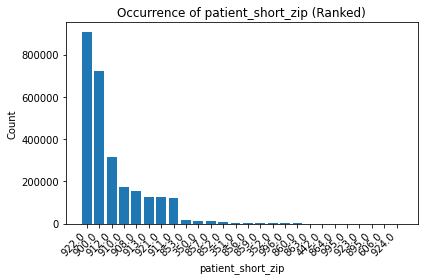

In [93]:
# Extract labels and values
labels = [item[0] for item in sorted_counts]
values = [item[1] for item in sorted_counts]

# Create the bar chart
plt.bar(labels, values)

# Labels and title 
plt.xlabel("patient_short_zip")
plt.ylabel("Count")
plt.title("Occurrence of patient_short_zip (Ranked)")

# Optional: Rotate x labels if they are long or overlapping
if len(labels) > 5:  
    plt.xticks(rotation=45, ha='right')  

# Adjust layout for better display
plt.tight_layout()
plt.show()

The bar chat above shows the count of patients based on their zip code, which is a geographic identifier. It shows that small number of zip codes have a very high occurrence in the dataset.

In [94]:
patients_gender_cnt = db_merged.groupby(['diag', 'patient_gender'])['journey_id'].nunique().reset_index(name = 'count')
total_cnt = patients_gender_cnt.groupby('diag')['count'].transform('sum')
patients_gender_cnt['gender_ratio'] = patients_gender_cnt['count']/total_cnt
patients_gender_cnt

,diag,patient_gender,count,gender_ratio
0,Obesity or Hypertension,F,4309,0.567198
1,Obesity or Hypertension,M,3288,0.432802


The table above shows the count and ratio of patients who got obesity or hypertensive group by gender. We can infer that females have a higher prevalence than males in this diagnosis.

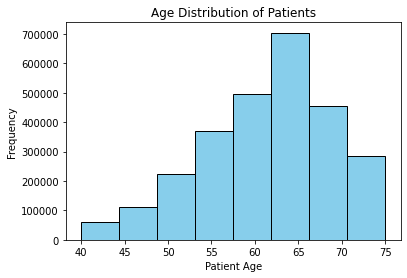

In [95]:
# Age distribution of patients 
plt.hist(db_merged['patient_age'], bins=8, color='skyblue', edgecolor='black')

plt.xlabel('Patient Age')
plt.ylabel('Frequency')
plt.title('Age Distribution of Patients')

# Show the histogram
plt.show()

The histogram above shows the age distribution of patients. The tallest bar represents the age range of 60-65, which is the most common age range among the patients. Meanwhile, there are fewer patients in the younger group (40-45) and older group (70-75).

(array([ 962114.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0., 1745834.]),
 array([2022. , 2022.1, 2022.2, 2022.3, 2022.4, 2022.5, 2022.6, 2022.7,
        2022.8, 2022.9, 2023. ]),
 <BarContainer object of 10 artists>)

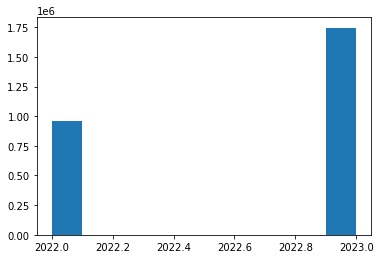

In [96]:
plt.hist(pd.to_datetime(db_merged['claim_date']).dt.year)

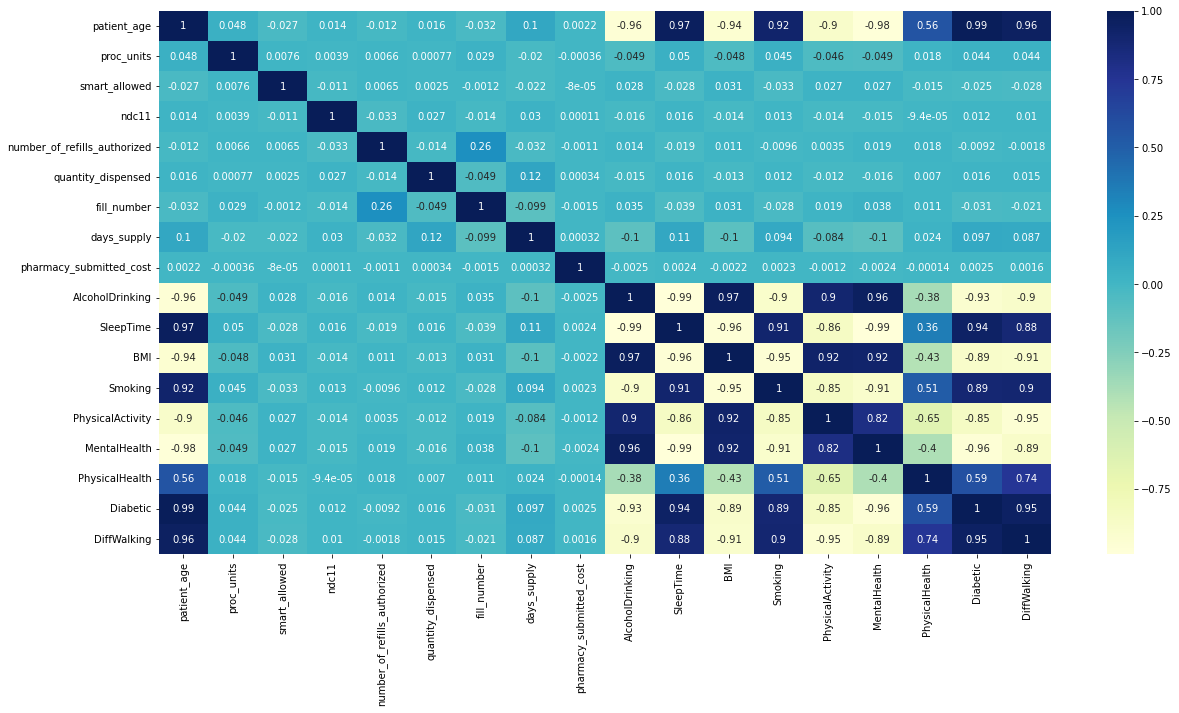

In [97]:
# Heat map
corrmat = db_merged.corr()
plt.figure(figsize=(20,10)) 
sns.heatmap(corrmat, cmap="YlGnBu", annot = True)
plt.show()

Based on the heatmap generated above, many variables seem to have low to negligible correlation with each other, as indicated by the lighter colors in most cells.


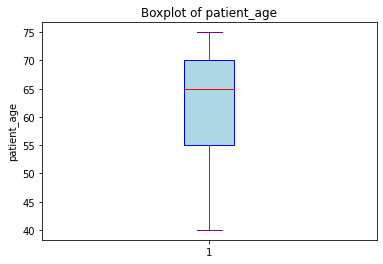

In [98]:
# Boxplot
columns_to_plot = ['patient_age']

for column in columns_to_plot:
    plt.figure()
    plt.boxplot(db_merged[column], patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'), 
                medianprops=dict(color='red'), whiskerprops=dict(color='green'),
                capprops=dict(color='purple'), flierprops=dict(markerfacecolor='yellow', marker='o'))
    plt.title(f'Boxplot of {column}')
    plt.ylabel(column)
    plt.show()

The red line on the box plot above means the median age of the patients, which is around 60 years. The bottom of the box shows the first quartile, which is approx 55 years and the top represents the third quartile, which is approx 65 years.

### Exploration on Treatment Group

In [99]:
# Create treatment group for patient who takes Ozempic
treatment_group = db_merged[db_merged['proc_code'] == "J3490"]
print(treatment_group.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3115 entries, 16327 to 2706423
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   journey_id                    3115 non-null   object        
 1   claim_date                    3115 non-null   datetime64[ns]
 2   patient_short_zip             3115 non-null   object        
 3   patient_age                   3115 non-null   float64       
 4   patient_gender                3115 non-null   object        
 5   visit_type                    3115 non-null   object        
 6   proc_code                     3115 non-null   object        
 7   proc_units                    3115 non-null   int64         
 8   smart_allowed                 3115 non-null   float64       
 9   date_of_service               3115 non-null   datetime64[ns]
 10  ndc11                         3115 non-null   int64         
 11  number_of_refills_autho

In [100]:
df_zip = treatment_group['patient_short_zip']

# Combine values 
combined_list = df_zip.values.flatten().tolist()
combined_list = [x for x in combined_list if pd.notna(x)]

# Process first three digits
zips = {}
for diag_code in combined_list:
    #first_three = diag_code[:3]
    zips[diag_code] = zips.get(diag_code, 0) + 1

sorted_counts = sorted(zips.items(), key=operator.itemgetter(1), reverse=True)

for items in sorted_counts:
    print(items)

('922.0', 1825)
('912.0', 519)
('921.0', 319)
('910.0', 172)
('911.0', 142)
('908.0', 116)
('859.0', 22)


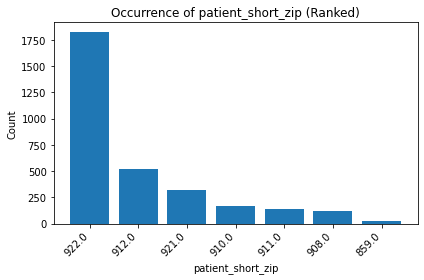

In [101]:
# Extract labels and values
labels = [item[0] for item in sorted_counts]
values = [item[1] for item in sorted_counts]

# Create the bar chart
plt.bar(labels, values)

# Labels and title 
plt.xlabel("patient_short_zip")
plt.ylabel("Count")
plt.title("Occurrence of patient_short_zip (Ranked)")

# Optional: Rotate x labels if they are long or overlapping
if len(labels) > 5:  
    plt.xticks(rotation=45, ha='right')  

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()

The bar chart above shows the occurrence of different patient_short_zip codes based on treatment group. Therefore, it shows that most of patients who got obesity and hypertension, and also took Ozempic for treatment live in the location with zip code 922.

In [102]:
patients_gender_cnt = treatment_group.groupby(['diag', 'patient_gender'])['journey_id'].nunique().reset_index(name = 'count')
total_cnt = patients_gender_cnt.groupby('diag')['count'].transform('sum')
patients_gender_cnt['gender_ratio'] = patients_gender_cnt['count']/total_cnt
patients_gender_cnt

,diag,patient_gender,count,gender_ratio
0,Obesity or Hypertension,F,36,0.62069
1,Obesity or Hypertension,M,22,0.37931


Again, the table above shows the split of patients who got obesity or hypertension by gender.

# **Causal Analysis Setup**

Potential Endogeneity Issues:

There might be factors which affect both the likelihood of being prescribed Ozempic and the health outcomes of interest. Therefore, the analysis without these variables will cause bias in the prediction. For example, some factors like income status or pharmacy cost can influence the treatment and predicted outcomes. What's more, if the treatment and predicted outcome influence each other, reverse causality will happen.


Strategy for addressing endogeneity:

To solve this problem, I used double lasso method. 

1. First plot lasso regression of all independent variables on dependent variable to find variables with significant coefficients on dependent variable.

2. Next plot lasso regression of all independent variables on treatment variable to find variables with significant coefficients on treatment variable.

3. Finally plot a regular linear regression with all identified variables with significant coefficients found in step 1 and 2 on dependent variable again.

This way with lasso variable selection can help solving endogeneity by identifying and including relevant confounders that might be omitted otherwise.


In [103]:
# Extract month and year from date of service
db_merged['Month'] = db_merged['date_of_service'].dt.month.astype(str)
db_merged['Year'] = db_merged['date_of_service'].dt.year.astype(str)

# Drop the original date column cause it's no longer needed
db_merged.drop(columns=['date_of_service'], inplace=True)

##### NDC code for ozempic: 
##### Resources:
- https://dailymed.nlm.nih.gov/dailymed/drugInfo.cfm?setid=adec4fd2-6858-4c99-91d4-531f5f2a2d79
- https://dailymed.nlm.nih.gov/dailymed/search.cfm?labeltype=all&query=ozempic

##### Novo Nordisk only

In [104]:
ozempic_ndcs = ["0169-4130-01", "0169-4130-13", "0169-4132-11", "0169-4132-12", "0169-4132-90", "0169-4132-97",
                 "0169-4136-02", "0169-4136-11", "0169-4181-03", "0169-4181-13", "0169-4181-90", "0169-4181-97", 
                 "0169-4772-11", "0169-4772-12", "0169-4772-90", "0169-4772-97"]
ozempic_ndcs = [int(x.replace("-", "")) for x in ozempic_ndcs]
rows_novo = (db_merged["ndc11"].isin(ozempic_ndcs))
rows_novo.sum()

29329

In [105]:
# Create a variable to show the treatment group: patients who take the ozempic
db_merged['ozempic_prescribed'] = (rows_novo | (db_merged['proc_code'] == "J3490")).astype(int)
print(db_merged['ozempic_prescribed'].value_counts())

0    2675513
1      32435
Name: ozempic_prescribed, dtype: int64


In [106]:
db_merged.columns

Index(['journey_id', 'claim_date', 'patient_short_zip', 'patient_age',
       'patient_gender', 'visit_type', 'proc_code', 'proc_units',
       'smart_allowed', 'ndc11', 'number_of_refills_authorized',
       'quantity_dispensed', 'fill_number', 'days_supply',
       'pharmacy_submitted_cost', 'diag', 'AgeCategory', 'AlcoholDrinking',
       'SleepTime', 'BMI', 'Smoking', 'PhysicalActivity', 'MentalHealth',
       'PhysicalHealth', 'Diabetic', 'DiffWalking', 'Month', 'Year',
       'ozempic_prescribed'],
      dtype='object')

In [107]:
independent_vars = [
    'patient_age',
    'patient_gender',
    'proc_units',
    'number_of_refills_authorized', 
    'quantity_dispensed', 
    'days_supply',  
    'fill_number',
    'pharmacy_submitted_cost',
    'Diabetic',
    'PhysicalHealth',
    'AlcoholDrinking',
    'MentalHealth',
    'Smoking',
    'PhysicalActivity', 
    'SleepTime', 
    'BMI', 
    'DiffWalking',
]

treatment_var = 'ozempic_prescribed'
dependent_var = 'smart_allowed'
columns_to_encode = ['Year', 'Month', 'visit_type']

In [108]:
# Some columns will not be used in model prediction
columns_to_drop = set(db_merged.columns) - set(independent_vars) - set([treatment_var, dependent_var]) - set(columns_to_encode)
columns_to_drop

{'AgeCategory',
 'claim_date',
 'diag',
 'journey_id',
 'ndc11',
 'patient_short_zip',
 'proc_code'}

In [109]:
db_merged.drop(columns=columns_to_drop, inplace=True)

# **Double Lasso Model Development**

In [110]:
# Set the patient_gender variable as binary data
gender_map = {'M': 0, 'F': 1}
db_merged['patient_gender'] = db_merged['patient_gender'].map(gender_map)
db_merged = pd.get_dummies(db_merged, columns=columns_to_encode)

In [111]:
independent_vars = list(set(db_merged.columns) - set([treatment_var, dependent_var]))

# Log outcome variable
db_merged[dependent_var] = np.log1p(db_merged[dependent_var])

# Split the data into training and testing sets
train, test = train_test_split(db_merged, train_size=0.8, random_state=2024, stratify=db_merged[treatment_var])

X_train, X_test = train[independent_vars], test[independent_vars]
y_train_treatment, y_test_treatment = train[treatment_var], test[treatment_var]
y_train_dependent, y_test_dependent = train[dependent_var], test[dependent_var]

#### 1. First plot lasso regression of all independent variables on dependent variable to find variables with significant coefficients on dependent variable.

In [112]:
lasso_first_stage = LassoCV(cv=10, random_state=2024).fit(X_train, y_train_dependent)
lasso_first_stage.coef_

array([-0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -1.35069441e-02,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -2.30527606e-03,  0.00000000e+00, -5.43797167e-01,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.80021375e-04,
        0.00000000e+00,  0.00000000e+00, -2.11690998e-05,  7.65432145e-09,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  3.37957106e-03,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00])

In [113]:
# Find filtered variables after using lasso
y_dependent_features = np.array(independent_vars)[lasso_first_stage.coef_ != 0]
y_dependent_features

array(['patient_age', 'days_supply', 'visit_type_laboratory visit',
       'proc_units', 'quantity_dispensed', 'pharmacy_submitted_cost',
       'number_of_refills_authorized'], dtype='<U41')

#### 2. Next plot lasso regression of all independent variables on treatment variable to find variables with significant coefficients on treatment variable.
##### Hence my treatment variable is binary data, use logistic regression

In [114]:
num_ozempic = (y_train_treatment == 1).sum()
row_indexes = [i for i in range(X_train.shape[0])]
num_sampling = 5
alpha = 0.05

coeff_to_remove = []
np.random.seed(2024)
treatment_model = LogisticRegression(penalty='l1', C=1/alpha, solver='liblinear')
for k in range(num_sampling):
    sampled = np.random.choice(row_indexes, size=num_ozempic, replace=False)
    treatment_model.fit(X_train.values[sampled,:], y_train_treatment.values[sampled])

    coeff_to_remove.extend(list(np.array(independent_vars)[(treatment_model.coef_ == 0)[0]]))

coeff_to_remove = set(coeff_to_remove)

In [115]:
y_treatment_features = [feature for feature in independent_vars if feature not in coeff_to_remove]
y_treatment_features

['Month_3',
 'SleepTime',
 'patient_age',
 'Month_2',
 'fill_number',
 'visit_type_non-hospital institution visit',
 'visit_type_emergency room visit',
 'days_supply',
 'visit_type_laboratory visit',
 'Month_10',
 'proc_units',
 'PhysicalHealth',
 'BMI',
 'quantity_dispensed',
 'pharmacy_submitted_cost',
 'Smoking',
 'patient_gender',
 'Month_12',
 'Year_2022',
 'Diabetic',
 'Month_1',
 'Month_8',
 'Month_9',
 'Month_11',
 'MentalHealth',
 'number_of_refills_authorized',
 'visit_type_inpatient visit',
 'visit_type_ambulance visit']

In [116]:
# Combine significant coefficients found in step 1 and 2
final_independent_vars = list(set(y_dependent_features).union(set(y_treatment_features))) + [treatment_var]
final_independent_vars

['Month_3',
 'SleepTime',
 'patient_age',
 'Month_2',
 'fill_number',
 'visit_type_non-hospital institution visit',
 'visit_type_emergency room visit',
 'days_supply',
 'visit_type_laboratory visit',
 'Month_10',
 'proc_units',
 'PhysicalHealth',
 'BMI',
 'quantity_dispensed',
 'pharmacy_submitted_cost',
 'Smoking',
 'patient_gender',
 'Month_12',
 'Year_2022',
 'Diabetic',
 'Month_1',
 'Month_8',
 'Month_9',
 'Month_11',
 'MentalHealth',
 'number_of_refills_authorized',
 'visit_type_inpatient visit',
 'visit_type_ambulance visit',
 'ozempic_prescribed']

In [117]:
# Finally plot a regular linear regression with all identified variables with significant coefficients found in step 1 and 2 on dependent variable again.
model = LinearRegression().fit(train[final_independent_vars], y_train_dependent)

#### **Double Lasso Model Evaluation & Interpretation**

In [118]:
# Evaluate Model Performance on Training Data
y_train_dependent_pred = model.predict(train[final_independent_vars])
train_mse = mean_squared_error(y_train_dependent, y_train_dependent_pred)
train_rmse = math.sqrt(train_mse)
train_r2 = r2_score(y_train_dependent, y_train_dependent_pred)  
print("Train MSE:", train_mse)
print("Train RMSE:", train_rmse)
print("Train R^2:", train_r2)

# Validate the Model on Testing Data
y_test_dependent_pred = model.predict(test[final_independent_vars])
test_mse = mean_squared_error(y_test_dependent, y_test_dependent_pred)
test_rmse = math.sqrt(test_mse)
test_r2 = r2_score(y_test_dependent, y_test_dependent_pred)  
print("Test MSE:", test_mse)
print("Test RMSE:", test_rmse)
print("Test R^2:", test_r2)

Train MSE: 2.6659389967624674
Train RMSE: 1.632770344158194
Train R^2: 0.08275532423577059
Test MSE: 2.679222563682836
Test RMSE: 1.6368330897445946
Test R^2: 0.08280784175891731


Interpretation:

The R square generated in test data is 0.083, which means about 8.3% of the variance in smart_allowed in the training set can be explained by the model. This is quite low, suggesting the model does not have a strong predictive power for smart_allowed. This result can be caused by missing predictors or the relationship between predictors and dependent variable smart_allowed is not well captured by the model.

The MSE and RMSE in both training and test data are consistant. It shows the model is stable across different datasets. However, the overall performance shows this stability does not imply usefulness for prediction.

# **Double Random Forest Development**

#### 1. First plot random forest regression of all independent variables on dependent variable to find significant variables on dependent variable.

In [119]:
# Find filtered variables after using random forest
rf_first_stage = SelectFromModel(RandomForestRegressor(n_estimators=10, random_state=42, n_jobs=-1))
rf_first_stage.fit(X_train.values, y_train_dependent.values)

SelectFromModel(estimator=RandomForestRegressor(n_estimators=10, n_jobs=-1,
                                                random_state=42))

In [120]:
y_dependent_features = X_train.columns[rf_first_stage.get_support()]
y_dependent_features.tolist()

['fill_number',
 'days_supply',
 'visit_type_laboratory visit',
 'proc_units',
 'quantity_dispensed',
 'pharmacy_submitted_cost',
 'number_of_refills_authorized']

#### 2. Next plot double lasso regression of all independent variables on treatment variable to find significant variables on treatment variable.

In [121]:
rf_second_stage = SelectFromModel(RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1))
rf_second_stage.fit(X_train.values, y_train_treatment.values)

y_treatment_features = X_train.columns[rf_second_stage.get_support()]

In [122]:
# Combine significant coefficients found in step 1 and 2
final_independent_vars = list(set(y_dependent_features).union(set(y_treatment_features))) + [treatment_var]
final_independent_vars

['visit_type_laboratory visit',
 'quantity_dispensed',
 'pharmacy_submitted_cost',
 'fill_number',
 'proc_units',
 'number_of_refills_authorized',
 'days_supply',
 'ozempic_prescribed']

In [123]:
# Finally fit RF with all identified variables with significant coefficients found in step 1 and 2 on dependent variable again.
model = RandomForestRegressor(n_estimators=10, random_state=42, n_jobs=-1).fit(train[final_independent_vars], y_train_dependent)

#### **Double Random Forest Model Evaluation & Interpretation**

In [124]:
# Evaluate Model Performance on Training Data
y_train_dependent_pred = model.predict(train[final_independent_vars])
train_mse = mean_squared_error(y_train_dependent, y_train_dependent_pred)
train_rmse = math.sqrt(train_mse)
train_r2 = r2_score(y_train_dependent, y_train_dependent_pred)  
print("Train MSE:", train_mse)
print("Train RMSE:", train_rmse)
print("Train R^2:", train_r2)

# Validate the Model on Testing Data
y_test_dependent_pred = model.predict(test[final_independent_vars])
test_mse = mean_squared_error(y_test_dependent, y_test_dependent_pred)
test_rmse = math.sqrt(test_mse)
test_r2 = r2_score(y_test_dependent, y_test_dependent_pred)  
print("Test MSE:", test_mse)
print("Test RMSE:", test_rmse)
print("Test R^2:", test_r2)

Train MSE: 1.4766613000723716
Train RMSE: 1.2151795340904865
Train R^2: 0.4919389689549041
Test MSE: 1.66996599038219
Test RMSE: 1.2922716395488179
Test R^2: 0.42831187984531816


The R square generated in test data is 0.428, which means about 42.8% of the variance in smart_allowed in the training set can be explained by the model. It increases compared with the result found by double lasso regression model, suggesting the model now has a strong predictive power for smart_allowed.

The MSE and RMSE in both training and test data are consistant. It shows the model is stable across different datasets. 

# **Additional Insights**

/Users/yuewenshen/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


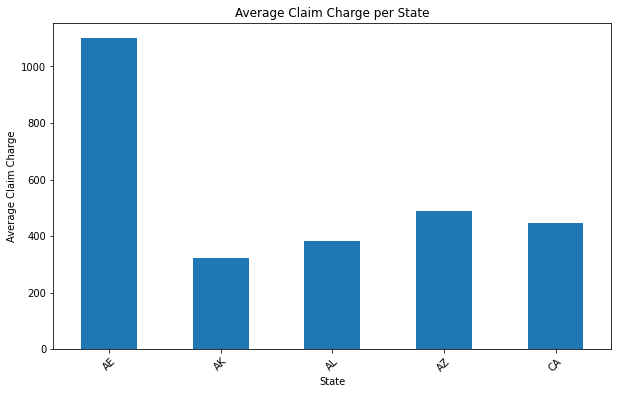

In [125]:
# read the original medical and prescription data
medical_row = pd.read_csv('./medical.csv')
medical_row = medical_row.drop_duplicates()
medical_row = medical_row[(medical_row['patient_age'] >= 40) & (medical_row['patient_age'] <= 75)]

scripts_row = pd.read_csv('./scripts.csv')
scripts_row = scripts_row.drop_duplicates()

# Plot the average claim charge per state
avg_claim_charge_state = medical_row.groupby('patient_state')['claim_charge'].mean()
avg_claim_charge_state.plot(kind='bar', figsize=(10, 6))
plt.title('Average Claim Charge per State')
plt.xlabel('State')
plt.ylabel('Average Claim Charge')
plt.xticks(rotation=45)
plt.show()

Based on the chart above, we can see that the "AE" state shows a significance difference in average claim charge compared with other states, which has the highest average claim charge. When doing the research on internet, I found that this state has a large number of armed forces, which offer a wide variety of insurance, so soldiers do not have to pay for medical care out of pocket, which may have contributed to the average claim charge in state.

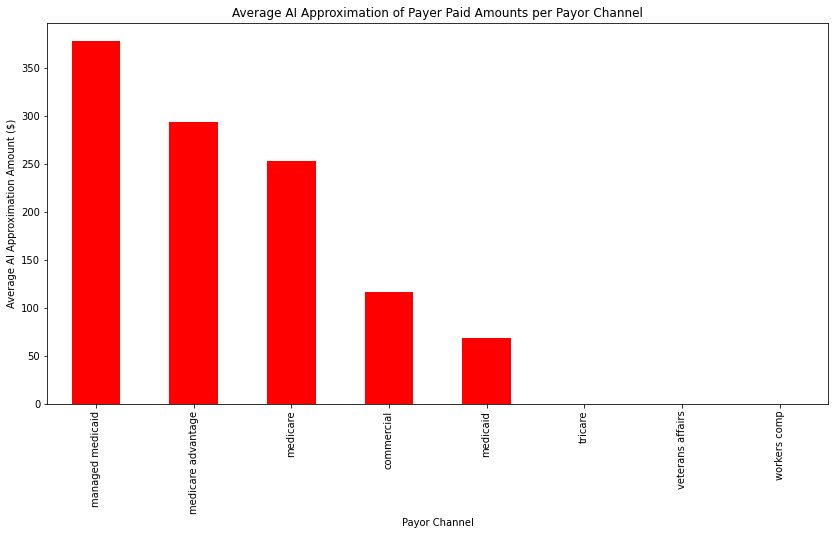

In [126]:
# Plot the average smart_allowed amount group by 'payor_channel'
avg_smart_allowed_per_channel = medical_row.groupby('payor_channel')['smart_allowed'].mean().sort_values(ascending=False)
avg_smart_allowed_per_channel.plot(kind='bar', figsize=(14, 7), color='red')
plt.title('Average AI Approximation of Payer Paid Amounts per Payor Channel')
plt.xlabel('Payor Channel')
plt.ylabel('Average AI Approximation Amount ($)')
plt.xticks(rotation=90)
plt.show()

The chart above shows the smart_allowed for each payment channel, where the "Managed Medicaid" has the highest payments, followed by "Medicare Advantage" and "Medicare." Then is "Commercial" and "Medicaid." Finally, we can see that the amounts for "Tricare," "Veterans Affairs," and "Workers Comp" are extreme low, which means that the amount of insurance coverage for these three categories is very high. Therefore, for those who want to get high medicine reimbursement, they should take these coverage into account.

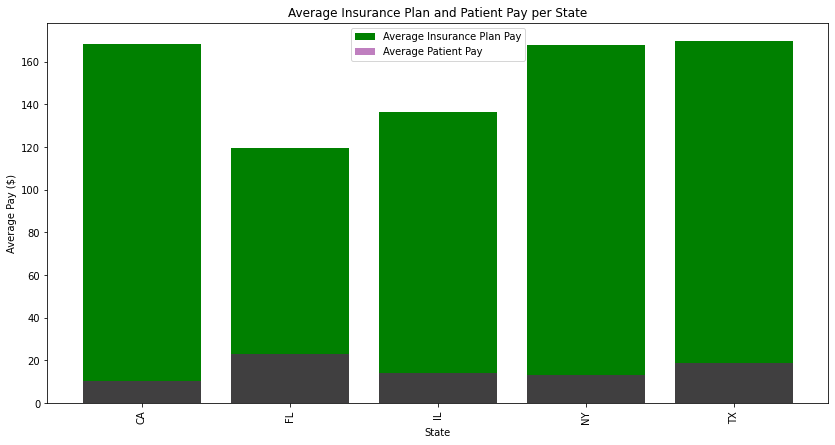

In [127]:
# Calculate the average insurance plan pay and average patient pay per state
avg_plan_pay_per_state = scripts_row.groupby('patient_state')['plan_pay'].mean()
avg_patient_pay_per_state = scripts_row.groupby('patient_state')['patient_pay'].mean()
# Plot average insurance plan and patient pay per state
plt.figure(figsize=(14, 7))
plt.bar(avg_plan_pay_per_state.index, avg_plan_pay_per_state, color='green', label='Average Insurance Plan Pay')
plt.bar(avg_patient_pay_per_state.index, avg_patient_pay_per_state, color='purple', alpha=0.5, label='Average Patient Pay')
plt.title('Average Insurance Plan and Patient Pay per State')
plt.xlabel('State')
plt.ylabel('Average Pay ($)')
plt.xticks(rotation=90)
plt.legend()
plt.show()

Finally, I looked at the average insurance plan payments in each state versus the average patient payments in each state and found that California, New York, and Texas all had very high insurance plan payments, probably because of the larger population during those three states. However, California perform best when comparing the ratio of average insurance plan payments to patients' own payments, which includes both high insurance payments and low patient payments. By contrast, patients in Texas pay relatively high rates.